<a href="https://colab.research.google.com/github/zuzka05/stat_learn/blob/main/frequency_scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frequency Scaling

This notebook explains frequency scaling with a concrete example. Frequency scaling is trading at a higher frequency to exploit a small statistical edge with more bets. You can predict (forecast) at a longer time horizon like 1 day but make more than 1 trade per day.

For example, in this notebook, we will use 1 hour OHLC timeseries to make trades every hour but forecast future return 30 days into the future. So instead of 1 trade per day, we are making 24 trades per day but hold for 30 days.

You could even use higher frequency time series data. For example, if you used 15min time series data, then you can make 96 trades a day (4 * 24). Thus, scaling your statistical edge even more.

## Example

Think of a coin with a tiny statistical edge of just 2 cents, if you toss it 10 times a day, it doesn't make a huge amount but if you tossed it a 1 million times a day then you will make lots of a day.

Let's empirically verify.

### Calculate Expected Value

In [11]:
0.51 * 1.0 + 0.49 * -1.0

0.020000000000000018

In [12]:
import random
import pandas as pd

random.seed(42)

def biased_coin_flip():
    # Returns +1 for a win, -1 for a loss
    return 1 if random.random() < 0.51 else -1

def simulate_coin_toss_trial(n):
    # Example: simulate 10 flips
    df =  pd.DataFrame({
        'toss': [biased_coin_flip() for _ in range(n)],
    })
    df['net'] = df['toss'].cumsum()
    return df


trail_df = simulate_coin_toss_trial(10)
trail_df

,toss,net
0,-1,-1
1,1,0
2,1,1
3,1,2
4,-1,1
5,-1,0
6,-1,-1
7,1,0
8,1,1
9,1,2


<Axes: >

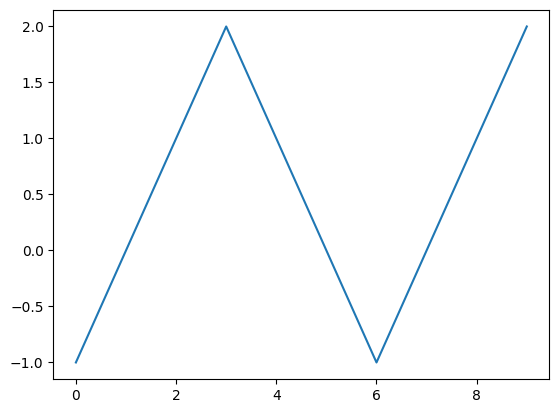

In [13]:
trail_df['net'].plot()

We can see after 10 tosses a day that we only made $2 and went into negative equity (where net < 0) twice!

Let's toss 1 million times a day instead!

In [14]:
trail_df = simulate_coin_toss_trial(1000000)
trail_df

,toss,net
0,1,1
1,1,2
2,1,3
3,1,4
4,-1,3
...,...,...
999995,1,19576
999996,-1,19575
999997,-1,19574
999998,1,19575


<Axes: >

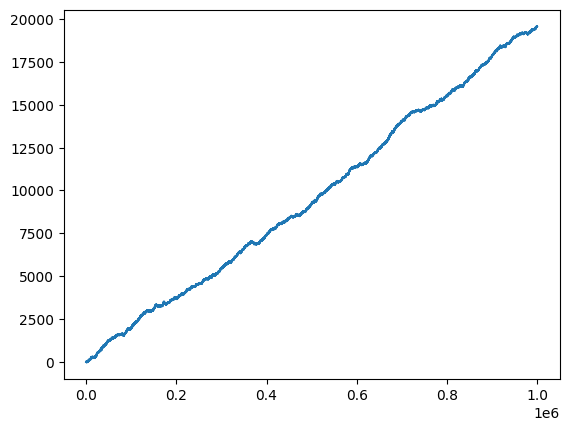

In [15]:
trail_df['net'].plot()

### How much did it make?

You can see that it made $19,576

In [16]:
trail_df['toss'].sum()

np.int64(19576)

### Evaluate Empirical Win Rate

You can see that the win rate is 50.9% yet it makes $19,576! So a very, very tiny statistical edge but you see the equity curve is like a straight line. By increasing the frequency of bets, the law of large numbers (LLN) kicks in.

In [17]:
trail_df['won'] = trail_df['toss'].map(lambda x: True if x > 0 else False)
trail_df['won'].mean()

np.float64(0.509788)

## Real-World Example

The previous was a toy example that demonstrates the principles of frequency scaling but let's now use a real-world example.

We will use 1 hour OHLC but make 30 day forecasts. Thus we trade every hour and hold for 30 days.

### Load up OHLC 1 hour time series

In [18]:
ts = pd.read_csv('MELANIAUSDT-1h-ohlc.csv')
ts

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,2025-01-20T09:00:00.000+0000,11.0000,11.4810,9.5700,10.6620,11384199.07,2025-01-20T09:59:59.999+0000,1.231390e+08,260948,5445930.66,5.899404e+07,0
1,2025-01-20T10:00:00.000+0000,10.6610,11.6940,10.5000,10.8480,12075271.07,2025-01-20T10:59:59.999+0000,1.343633e+08,382369,5854709.03,6.518769e+07,0
2,2025-01-20T11:00:00.000+0000,10.8480,11.0840,9.3810,9.5930,12843489.69,2025-01-20T11:59:59.999+0000,1.291159e+08,395669,6221973.06,6.251548e+07,0
3,2025-01-20T12:00:00.000+0000,9.5920,10.1100,7.8890,8.5610,21465129.93,2025-01-20T12:59:59.999+0000,1.919756e+08,484420,10232073.31,9.171677e+07,0
4,2025-01-20T13:00:00.000+0000,8.5650,8.7850,7.4100,7.9000,19772796.14,2025-01-20T13:59:59.999+0000,1.590931e+08,463466,9713763.14,7.826701e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7402,2025-11-24T19:00:00.000+0000,0.1325,0.1337,0.1292,0.1298,2802078.94,2025-11-24T19:59:59.999+0000,3.680209e+05,3166,1125561.23,1.479018e+05,0
7403,2025-11-24T20:00:00.000+0000,0.1299,0.1325,0.1294,0.1322,2156768.69,2025-11-24T20:59:59.999+0000,2.820491e+05,2749,1351718.72,1.767220e+05,0
7404,2025-11-24T21:00:00.000+0000,0.1321,0.1322,0.1290,0.1297,1666444.52,2025-11-24T21:59:59.999+0000,2.173586e+05,2703,656671.32,8.559823e+04,0
7405,2025-11-24T22:00:00.000+0000,0.1297,0.1312,0.1297,0.1304,709641.03,2025-11-24T22:59:59.999+0000,9.254184e+04,1311,401705.44,5.238444e+04,0


### Add DateTime Index

We want to use a DateTime index so we can re-sample the data to 30 day time series.

In [19]:
ts['open_time'] = pd.to_datetime(ts['open_time'])
ts = ts.set_index('open_time')
ts

,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
open_time,,,,,,,,,,,
2025-01-20 09:00:00+00:00,11.0000,11.4810,9.5700,10.6620,11384199.07,2025-01-20T09:59:59.999+0000,1.231390e+08,260948,5445930.66,5.899404e+07,0
2025-01-20 10:00:00+00:00,10.6610,11.6940,10.5000,10.8480,12075271.07,2025-01-20T10:59:59.999+0000,1.343633e+08,382369,5854709.03,6.518769e+07,0
2025-01-20 11:00:00+00:00,10.8480,11.0840,9.3810,9.5930,12843489.69,2025-01-20T11:59:59.999+0000,1.291159e+08,395669,6221973.06,6.251548e+07,0
2025-01-20 12:00:00+00:00,9.5920,10.1100,7.8890,8.5610,21465129.93,2025-01-20T12:59:59.999+0000,1.919756e+08,484420,10232073.31,9.171677e+07,0
2025-01-20 13:00:00+00:00,8.5650,8.7850,7.4100,7.9000,19772796.14,2025-01-20T13:59:59.999+0000,1.590931e+08,463466,9713763.14,7.826701e+07,0
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-24 19:00:00+00:00,0.1325,0.1337,0.1292,0.1298,2802078.94,2025-11-24T19:59:59.999+0000,3.680209e+05,3166,1125561.23,1.479018e+05,0
2025-11-24 20:00:00+00:00,0.1299,0.1325,0.1294,0.1322,2156768.69,2025-11-24T20:59:59.999+0000,2.820491e+05,2749,1351718.72,1.767220e+05,0
2025-11-24 21:00:00+00:00,0.1321,0.1322,0.1290,0.1297,1666444.52,2025-11-24T21:59:59.999+0000,2.173586e+05,2703,656671.32,8.559823e+04,0


In [20]:
ts.index

DatetimeIndex(['2025-01-20 09:00:00+00:00', '2025-01-20 10:00:00+00:00',
               '2025-01-20 11:00:00+00:00', '2025-01-20 12:00:00+00:00',
               '2025-01-20 13:00:00+00:00', '2025-01-20 14:00:00+00:00',
               '2025-01-20 15:00:00+00:00', '2025-01-20 16:00:00+00:00',
               '2025-01-20 17:00:00+00:00', '2025-01-20 18:00:00+00:00',
               ...
               '2025-11-24 14:00:00+00:00', '2025-11-24 15:00:00+00:00',
               '2025-11-24 16:00:00+00:00', '2025-11-24 17:00:00+00:00',
               '2025-11-24 18:00:00+00:00', '2025-11-24 19:00:00+00:00',
               '2025-11-24 20:00:00+00:00', '2025-11-24 21:00:00+00:00',
               '2025-11-24 22:00:00+00:00', '2025-11-24 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='open_time', length=7407, freq=None)

### Add 30-Day Log Returns

We are going to add 30 day log returns because our model is going to forecast the future log return 30 days ahead but using 1 hour interval time series.

We also add a lag that we use for predictions. The lag in this context is the previous close log return.

The end-goal is that we make a trade (bet) every 1 hour but close the trade 30 days afterwards.

In [21]:
import numpy as np
time_step = 30 * 24 # calculates the number of 1 hour ticks in 30 days
ts['close_lag_1'] = ts['close'].shift(time_step)
ts['close_log_return'] = np.log(ts['close']/ts['close_lag_1'])
ts['close_return'] = (ts['close']-ts['close_lag_1'])/ts['close_lag_1']
ts['close_log_return_lag_1'] = ts['close_log_return'].shift(time_step)

ts[['close','close_lag_1','close_log_return','close_log_return_lag_1']]

,close,close_lag_1,close_log_return,close_log_return_lag_1
open_time,,,,
2025-01-20 09:00:00+00:00,10.6620,NaN,NaN,NaN
2025-01-20 10:00:00+00:00,10.8480,NaN,NaN,NaN
2025-01-20 11:00:00+00:00,9.5930,NaN,NaN,NaN
2025-01-20 12:00:00+00:00,8.5610,NaN,NaN,NaN
2025-01-20 13:00:00+00:00,7.9000,NaN,NaN,NaN
...,...,...,...,...
2025-11-24 19:00:00+00:00,0.1298,0.1002,0.258827,-0.484125
2025-11-24 20:00:00+00:00,0.1322,0.0998,0.281148,-0.480718
2025-11-24 21:00:00+00:00,0.1297,0.0994,0.266072,-0.492141


If we look at the auto-correlation, we see the's a small negative serial correlation between the close log return and its first lag.

In [22]:
ts[['close_log_return','close_log_return_lag_1']].corr()

,close_log_return,close_log_return_lag_1
close_log_return,1.000000,-0.066385
close_log_return_lag_1,-0.066385,1.000000


### Add Directional Signal

The directional signal is the direction that the trade should go in:

* Long => bet going up => 1
* Short => bet going down => -1

We will not use machine learning but just a simple heuristic that if the previous log return was positive, we will bet that the future log return (close_log_return) will go up,and vice verse, if the previous log return is negative, bet the future log return will be negative.

This is essentially a primtive momentum based trading signal.

You might be wondering why not using mean reversion when there's negative serial correlation but try to use -1 * np.sign(ts['close_log_return_lag_1']) instead; you will see there's no edge.

In [23]:
ts['dir_signal'] = 1 * np.sign(ts['close_log_return_lag_1'])
ts[['dir_signal','close_log_return','close_log_return_lag_1']].dropna()

,dir_signal,close_log_return,close_log_return_lag_1
open_time,,,
2025-03-21 09:00:00+00:00,-1.0,-0.555780,-2.154806
2025-03-21 10:00:00+00:00,-1.0,-0.570730,-2.165649
2025-03-21 11:00:00+00:00,-1.0,-0.579990,-2.036291
2025-03-21 12:00:00+00:00,-1.0,-0.567984,-1.940203
2025-03-21 13:00:00+00:00,-1.0,-0.565282,-1.852558
...,...,...,...
2025-11-24 19:00:00+00:00,-1.0,0.258827,-0.484125
2025-11-24 20:00:00+00:00,-1.0,0.281148,-0.480718
2025-11-24 21:00:00+00:00,-1.0,0.266072,-0.492141


In [24]:
ts['close_log_return'].autocorr(lag=1)

np.float64(0.9973937230624229)

### Add Trade Log Return

Add trade return to see model if we open a trade and close it in 30 days time, every 1 hour.

In [25]:
ts['trade_log_return'] = ts['dir_signal'] * ts['close_log_return']
ts[['dir_signal','close_return','trade_log_return']]

,dir_signal,close_return,trade_log_return
open_time,,,
2025-01-20 09:00:00+00:00,NaN,NaN,NaN
2025-01-20 10:00:00+00:00,NaN,NaN,NaN
2025-01-20 11:00:00+00:00,NaN,NaN,NaN
2025-01-20 12:00:00+00:00,NaN,NaN,NaN
2025-01-20 13:00:00+00:00,NaN,NaN,NaN
...,...,...,...
2025-11-24 19:00:00+00:00,-1.0,0.295409,-0.258827
2025-11-24 20:00:00+00:00,-1.0,0.324649,-0.281148
2025-11-24 21:00:00+00:00,-1.0,0.304829,-0.266072


In [26]:
# Momentum signal
ts['pnl_momentum'] = ts['dir_signal'] * ts['close_log_return']

# Mean reversion signal
ts['dir_signal_mr'] = -1 * np.sign(ts['close_log_return_lag_1'])
ts['pnl_mean_reversion'] = ts['dir_signal_mr'] * ts['close_log_return']

# Compare
print(f"Momentum total PnL: {ts['pnl_momentum'].sum()}")
print(f"Mean reversion total PnL: {ts['pnl_mean_reversion'].sum()}")

Momentum total PnL: 1137.0981502948785
Mean reversion total PnL: -1137.0981502948785


In [27]:
"""
This positive autocorrelation at short horizons (hourly data) is common in crypto because of:

Momentum cascades: Large orders split across time create persistent price pressure
Trend following algorithms: Many bots chase momentum, creating positive feedback
Information diffusion: News/events take time to be fully reflected in price
Order flow imbalances: Directional flow persists over multiple periods


Interestingly, the autocorrelation structure often depends on the timeframe:
Very short term (tick, seconds): Often mean reversion due to bid-ask bounce
Short term (minutes, hours): Often momentum due to order flow
Medium term (days, weeks): Can show mean reversion as prices correct

"""

'\nThis positive autocorrelation at short horizons (hourly data) is common in crypto because of:\n\nMomentum cascades: Large orders split across time create persistent price pressure\nTrend following algorithms: Many bots chase momentum, creating positive feedback\nInformation diffusion: News/events take time to be fully reflected in price\nOrder flow imbalances: Directional flow persists over multiple periods\n\n\nInterestingly, the autocorrelation structure often depends on the timeframe:\nVery short term (tick, seconds): Often mean reversion due to bid-ask bounce\nShort term (minutes, hours): Often momentum due to order flow\nMedium term (days, weeks): Can show mean reversion as prices correct\n\n'

In [28]:
#You can verify which signal has edge by checking the correlation between signal and future returns

# Momentum signal correlation
corr_momentum = (ts['dir_signal'] * ts['close_log_return']).mean()

# Mean reversion signal correlation
corr_mr = (-ts['dir_signal'] * ts['close_log_return']).mean()

print(f"Momentum edge: {corr_momentum:.6f}")
print(f"Mean reversion edge: {corr_mr:.6f}")

Momentum edge: 0.190564
Mean reversion edge: -0.190564


### Add Trade Size & Gross PnL

We don't want to use log returns because we are not opening and closing positions sequentially and re-investing. Instead we want to use simple returns.

### Convert Log Returns back to Simple Returns

In [29]:
np.exp(ts['trade_log_return'])

,trade_log_return
open_time,
2025-01-20 09:00:00+00:00,NaN
2025-01-20 10:00:00+00:00,NaN
2025-01-20 11:00:00+00:00,NaN
2025-01-20 12:00:00+00:00,NaN
2025-01-20 13:00:00+00:00,NaN
...,...
2025-11-24 19:00:00+00:00,0.771957
2025-11-24 20:00:00+00:00,0.754917
2025-11-24 21:00:00+00:00,0.766384


<Axes: xlabel='open_time'>

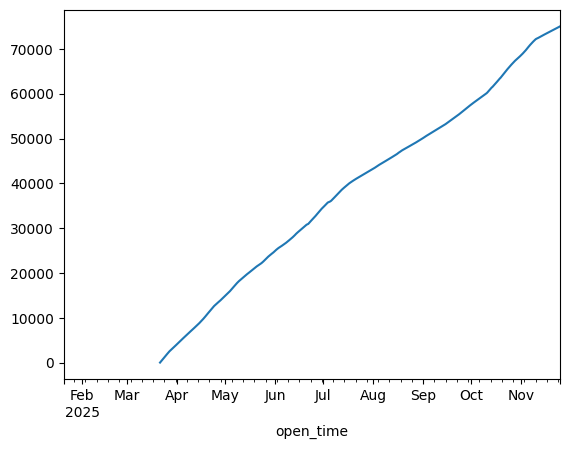

In [30]:
trade_size = 10
ts['trade_gross_pnl'] = np.exp(ts['trade_log_return']) * trade_size
ts['trade_gross_pnl'].cumsum().plot()

### Max Capital Allocation

We need to work out what's the max amount of capital allocated at a time.

In [31]:
time_step * trade_size

7200

### Split the data

It's very important to split the data into in-sample and out-of-sample. In machine learning, it's called splitting into train and test datasets. The train dataset is for training a model to learn a pattern and the test is for testing the model's predictive power.

It's really important to split by time - preserving temporal order.

In [32]:
def split_data(df, test_size=0.25):
    train_size = 1 - test_size
    i = int(len(df) * train_size)
    return df[:i], df[i:]

in_sample, out_sample = split_data(ts)

In [33]:
in_sample

,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,...,close_lag_1,close_log_return,close_return,close_log_return_lag_1,dir_signal,trade_log_return,pnl_momentum,dir_signal_mr,pnl_mean_reversion,trade_gross_pnl
open_time,,,,,,,,,,,,,,,,,,,,,
2025-01-20 09:00:00+00:00,11.0000,11.4810,9.5700,10.6620,11384199.07,2025-01-20T09:59:59.999+0000,1.231390e+08,260948,5445930.66,5.899404e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-20 10:00:00+00:00,10.6610,11.6940,10.5000,10.8480,12075271.07,2025-01-20T10:59:59.999+0000,1.343633e+08,382369,5854709.03,6.518769e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-20 11:00:00+00:00,10.8480,11.0840,9.3810,9.5930,12843489.69,2025-01-20T11:59:59.999+0000,1.291159e+08,395669,6221973.06,6.251548e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-20 12:00:00+00:00,9.5920,10.1100,7.8890,8.5610,21465129.93,2025-01-20T12:59:59.999+0000,1.919756e+08,484420,10232073.31,9.171677e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-20 13:00:00+00:00,8.5650,8.7850,7.4100,7.9000,19772796.14,2025-01-20T13:59:59.999+0000,1.590931e+08,463466,9713763.14,7.826701e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-08 15:00:00+00:00,0.2016,0.2042,0.2008,0.2020,4680366.57,2025-09-08T15:59:59.999+0000,9.482345e+05,4510,2280901.61,4.620526e+05,...,0.2273,-0.118003,-0.111307,0.154811,1.0,-0.118003,-0.118003,-1.0,0.118003,8.886934
2025-09-08 16:00:00+00:00,0.2019,0.2028,0.2000,0.2004,2091935.56,2025-09-08T16:59:59.999+0000,4.217470e+05,2319,979580.96,1.975355e+05,...,0.2269,-0.124194,-0.116792,0.132210,1.0,-0.124194,-0.124194,-1.0,0.124194,8.832085
2025-09-08 17:00:00+00:00,0.2005,0.2019,0.1998,0.2004,1628770.10,2025-09-08T17:59:59.999+0000,3.268314e+05,3380,885163.20,1.777163e+05,...,0.2286,-0.131658,-0.123360,0.111895,1.0,-0.131658,-0.131658,-1.0,0.131658,8.766404


In [34]:
out_sample

,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,...,close_lag_1,close_log_return,close_return,close_log_return_lag_1,dir_signal,trade_log_return,pnl_momentum,dir_signal_mr,pnl_mean_reversion,trade_gross_pnl
open_time,,,,,,,,,,,,,,,,,,,,,
2025-09-08 20:00:00+00:00,0.1998,0.2005,0.1974,0.1989,3011576.01,2025-09-08T20:59:59.999+0000,598252.878467,3724,1354996.32,269221.298790,...,0.2327,-0.156948,-0.145251,0.116548,1.0,-0.156948,-0.156948,-1.0,0.156948,8.547486
2025-09-08 21:00:00+00:00,0.1990,0.2007,0.1988,0.2002,1092088.45,2025-09-08T21:59:59.999+0000,218236.491004,1710,538461.47,107655.530634,...,0.2301,-0.139197,-0.129944,0.107729,1.0,-0.139197,-0.139197,-1.0,0.139197,8.700565
2025-09-08 22:00:00+00:00,0.2001,0.2006,0.1989,0.1993,2279239.84,2025-09-08T22:59:59.999+0000,455394.303374,1972,1015413.56,202707.556904,...,0.2293,-0.140220,-0.130833,0.085071,1.0,-0.140220,-0.140220,-1.0,0.140220,8.691670
2025-09-08 23:00:00+00:00,0.1994,0.1997,0.1987,0.1991,559000.51,2025-09-08T23:59:59.999+0000,111348.526789,839,268537.57,53478.448064,...,0.2290,-0.139915,-0.130568,0.087567,1.0,-0.139915,-0.139915,-1.0,0.139915,8.694323
2025-09-09 00:00:00+00:00,0.1992,0.2009,0.1987,0.2008,2646895.00,2025-09-09T00:59:59.999+0000,529172.646929,2978,1705709.64,340908.933952,...,0.2315,-0.142270,-0.132613,0.119134,1.0,-0.142270,-0.142270,-1.0,0.142270,8.673866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-24 19:00:00+00:00,0.1325,0.1337,0.1292,0.1298,2802078.94,2025-11-24T19:59:59.999+0000,368020.932035,3166,1125561.23,147901.843397,...,0.1002,0.258827,0.295409,-0.484125,-1.0,-0.258827,-0.258827,1.0,0.258827,7.719569
2025-11-24 20:00:00+00:00,0.1299,0.1325,0.1294,0.1322,2156768.69,2025-11-24T20:59:59.999+0000,282049.053477,2749,1351718.72,176722.012247,...,0.0998,0.281148,0.324649,-0.480718,-1.0,-0.281148,-0.281148,1.0,0.281148,7.549168
2025-11-24 21:00:00+00:00,0.1321,0.1322,0.1290,0.1297,1666444.52,2025-11-24T21:59:59.999+0000,217358.594789,2703,656671.32,85598.225699,...,0.0994,0.266072,0.304829,-0.492141,-1.0,-0.266072,-0.266072,1.0,0.266072,7.663840


<Axes: xlabel='open_time'>

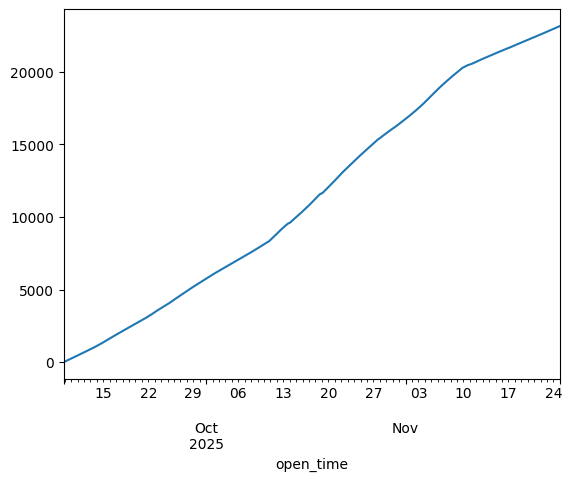

In [35]:
out_sample['trade_gross_pnl'].cumsum().plot()

### Compare against using no frequency scaling

We want to create a 30 day time series so each time interval is 30 days and not 1 hour. The time step is just 1 and not 24 * 30.

### Create 30-day time series

In [36]:
ts_30d = ts.resample('30D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
})
ts_30d

,open,high,low,close
open_time,,,,
2025-01-20 00:00:00+00:00,11.0000,11.6940,1.1920,1.2460
2025-02-19 00:00:00+00:00,1.2470,1.2980,0.5680,0.7260
2025-03-21 00:00:00+00:00,0.7260,0.7400,0.3910,0.4003
2025-04-20 00:00:00+00:00,0.4004,0.5836,0.3001,0.3439
2025-05-20 00:00:00+00:00,0.3440,0.4068,0.2382,0.2535
2025-06-19 00:00:00+00:00,0.2536,0.2880,0.1641,0.2449
2025-07-19 00:00:00+00:00,0.2450,0.2744,0.1881,0.2181
2025-08-18 00:00:00+00:00,0.2182,0.2213,0.1817,0.1985
2025-09-17 00:00:00+00:00,0.1986,0.2050,0.0442,0.1082


### Create data

In [37]:
ts_30d['close_lag_1'] = ts_30d['close'].shift()
ts_30d['close_log_return'] = np.log(ts_30d['close']/ts_30d['close_lag_1'])
ts_30d['close_log_return_lag_1'] = ts_30d['close_log_return'].shift()
ts_30d[['close','close_lag_1','close_log_return','close_log_return_lag_1']]

,close,close_lag_1,close_log_return,close_log_return_lag_1
open_time,,,,
2025-01-20 00:00:00+00:00,1.2460,NaN,NaN,NaN
2025-02-19 00:00:00+00:00,0.7260,1.2460,-0.540144,NaN
2025-03-21 00:00:00+00:00,0.4003,0.7260,-0.595336,-0.540144
2025-04-20 00:00:00+00:00,0.3439,0.4003,-0.151863,-0.595336
2025-05-20 00:00:00+00:00,0.2535,0.3439,-0.304987,-0.151863
2025-06-19 00:00:00+00:00,0.2449,0.2535,-0.034514,-0.304987
2025-07-19 00:00:00+00:00,0.2181,0.2449,-0.115896,-0.034514
2025-08-18 00:00:00+00:00,0.1985,0.2181,-0.094165,-0.115896
2025-09-17 00:00:00+00:00,0.1082,0.1985,-0.606808,-0.094165


### Add Directional Signal

In [38]:
ts_30d['dir_signal'] = np.sign(ts_30d['close_log_return_lag_1']) * 1
ts_30d[['close','close_lag_1','close_log_return','close_log_return_lag_1', 'dir_signal']]

,close,close_lag_1,close_log_return,close_log_return_lag_1,dir_signal
open_time,,,,,
2025-01-20 00:00:00+00:00,1.2460,NaN,NaN,NaN,NaN
2025-02-19 00:00:00+00:00,0.7260,1.2460,-0.540144,NaN,NaN
2025-03-21 00:00:00+00:00,0.4003,0.7260,-0.595336,-0.540144,-1.0
2025-04-20 00:00:00+00:00,0.3439,0.4003,-0.151863,-0.595336,-1.0
2025-05-20 00:00:00+00:00,0.2535,0.3439,-0.304987,-0.151863,-1.0
2025-06-19 00:00:00+00:00,0.2449,0.2535,-0.034514,-0.304987,-1.0
2025-07-19 00:00:00+00:00,0.2181,0.2449,-0.115896,-0.034514,-1.0
2025-08-18 00:00:00+00:00,0.1985,0.2181,-0.094165,-0.115896,-1.0
2025-09-17 00:00:00+00:00,0.1082,0.1985,-0.606808,-0.094165,-1.0


In [39]:
ts_30d['trade_log_return'] =  ts_30d['dir_signal'] * ts_30d['close_log_return']
ts_30d[['close','close_lag_1','close_log_return','close_log_return_lag_1', 'dir_signal', 'trade_log_return']]

,close,close_lag_1,close_log_return,close_log_return_lag_1,dir_signal,trade_log_return
open_time,,,,,,
2025-01-20 00:00:00+00:00,1.2460,NaN,NaN,NaN,NaN,NaN
2025-02-19 00:00:00+00:00,0.7260,1.2460,-0.540144,NaN,NaN,NaN
2025-03-21 00:00:00+00:00,0.4003,0.7260,-0.595336,-0.540144,-1.0,0.595336
2025-04-20 00:00:00+00:00,0.3439,0.4003,-0.151863,-0.595336,-1.0,0.151863
2025-05-20 00:00:00+00:00,0.2535,0.3439,-0.304987,-0.151863,-1.0,0.304987
2025-06-19 00:00:00+00:00,0.2449,0.2535,-0.034514,-0.304987,-1.0,0.034514
2025-07-19 00:00:00+00:00,0.2181,0.2449,-0.115896,-0.034514,-1.0,0.115896
2025-08-18 00:00:00+00:00,0.1985,0.2181,-0.094165,-0.115896,-1.0,0.094165
2025-09-17 00:00:00+00:00,0.1082,0.1985,-0.606808,-0.094165,-1.0,0.606808


In [40]:
ts_30d['trade_size'] = trade_size
ts_30d['trade_gross_pnl'] = trade_size * np.exp(ts_30d['trade_log_return'])
ts_30d[['close','close_lag_1','close_log_return','close_log_return_lag_1', 'dir_signal', 'trade_log_return','trade_size','trade_gross_pnl']]

,close,close_lag_1,close_log_return,close_log_return_lag_1,dir_signal,trade_log_return,trade_size,trade_gross_pnl
open_time,,,,,,,,
2025-01-20 00:00:00+00:00,1.2460,NaN,NaN,NaN,NaN,NaN,10,NaN
2025-02-19 00:00:00+00:00,0.7260,1.2460,-0.540144,NaN,NaN,NaN,10,NaN
2025-03-21 00:00:00+00:00,0.4003,0.7260,-0.595336,-0.540144,-1.0,0.595336,10,18.136398
2025-04-20 00:00:00+00:00,0.3439,0.4003,-0.151863,-0.595336,-1.0,0.151863,10,11.640012
2025-05-20 00:00:00+00:00,0.2535,0.3439,-0.304987,-0.151863,-1.0,0.304987,10,13.566075
2025-06-19 00:00:00+00:00,0.2449,0.2535,-0.034514,-0.304987,-1.0,0.034514,10,10.351164
2025-07-19 00:00:00+00:00,0.2181,0.2449,-0.115896,-0.034514,-1.0,0.115896,10,11.228794
2025-08-18 00:00:00+00:00,0.1985,0.2181,-0.094165,-0.115896,-1.0,0.094165,10,10.987406
2025-09-17 00:00:00+00:00,0.1082,0.1985,-0.606808,-0.094165,-1.0,0.606808,10,18.345656


### Compare No. Trades

In [41]:
ts['trade_gross_pnl'].count()

np.int64(5967)

In [42]:
ts_30d['trade_gross_pnl'].count()

np.int64(9)

### Compare Gross Profit

In [43]:
ts['trade_gross_pnl'].sum()

np.float64(74995.54808570736)

In [44]:
ts_30d['trade_gross_pnl'].sum()

np.float64(110.47393392306489)

Compare the ratio:

In [45]:
ts['trade_gross_pnl'].sum() / ts_30d['trade_gross_pnl'].sum()

np.float64(678.8528788875661)

You can see that we make way more using frequency scaling. It's still the same statistical edge.

### Compare Trading Volume

In [46]:
ts['trade_gross_pnl'].sum() * 2

np.float64(149991.0961714147)

In [47]:
ts_30d['trade_gross_pnl'].sum() * 2

np.float64(220.94786784612978)

You can see we are trading way more volume. By trading more, we will get better fees as they are typically lowered by increasing trading volume. However we need more cpaital to use frequency scaling.

### Compare Win Rate

In [48]:
ts['trade_gross_pnl'].map(lambda x: 1 if x>0 else 0).mean()

np.float64(0.8055893074119077)

In [49]:
ts_30d['trade_gross_pnl'].map(lambda x: 1 if x>0 else 0).mean()

np.float64(0.8181818181818182)

The win rate is similar so there isn't a huge change when increasing the frequency.

### Compare Expected Value

In [50]:
ts['trade_gross_pnl'].mean()

np.float64(12.568384126982966)

In [51]:
ts_30d['trade_gross_pnl'].mean()

np.float64(12.27488154700721)

This also confirms that our edge remains the same when increasing frequency as the EV is roughly identical.

### Conclusion

* Hopefully you can see what is frequency scaling and how it scales a statistical edge.
* By increasing the number of trades, we dramatically increased our P&L but it didn't affect our profitability statistics like win rate and EV.
* Frequency scaling takes advantage of the Law of Large Numbers
* We can use scale-invariant statistics to ensure the statistical edge persists at higher frequencies.